# TuFT-Countdown RL

This notebook demonstrates a minimal RL fine-tuning workflow on the **Countdown** dataset using **TuFT**:

- Load + preprocess the Countdown dataset
- Define a reward function (format check + validity + numeric correctness)
- Run a minimal **GRPO-like** RL loop (sampling + importance-sampling loss)
- Periodically evaluate and optionally plot metrics + save a final checkpoint


## 0) Prerequisites
the experiments below were conducted on a local 2× NVIDIA A100-SXM4-80GB setup (Driver 550.54.15, CUDA 12.9).

- TuFT server running (e.g. `http://localhost:xxxx`)
- API key available
- Dependencies installed: `tinker datasets torch matplotlib`

Notes:
- If you use a mirrored Hugging Face endpoint, set `HF_ENDPOINT` before loading datasets/models.


In [1]:
# !pip install -U tinker datasets torch matplotlib

import re
from dataclasses import dataclass

import datasets
import matplotlib.pyplot as plt
import tinker
import torch
from datasets import Dataset
from tinker import types
from tinker.types.tensor_data import TensorData


print("Imports OK: tinker =", getattr(tinker, "__version__", "unknown"))

Imports OK: tinker = 0.8.1


## 1) Configuration

In [2]:
# TuFT server
TINKER_BASE_URL = "http://localhost:8080"
TINKER_API_KEY = "tml-test-key"

# Dataset (Countdown)
DATASET_NAME = "Jiayi-Pan/Countdown-Tasks-3to4"

# Model
BASE_MODEL = "Qwen/Qwen3-0.6B"
LORA_RANK = 8

# Training
NUM_STEPS = 1000
BATCH_SIZE = 4
GROUP_SIZE = 16
LEARNING_RATE = 1e-4
MAX_TOKENS = 128

# Train sampling
TEMPERATURE = 0.9

# Dataset split
TEST_SIZE = 512
SEED = 0

# Reward shaping
FORMAT_SCORE = 0.1
USE_CONTINUOUS_SHAPING = True

# Evaluation
EVAL_EVERY = 30
EVAL_BATCH_SIZE = 64
EVAL_GROUP_SIZE = 1
EVAL_TEMPERATURE = 0.1
REWARD_EMA_ALPHA = 0.1


print("=== CONFIG ===")
print("Server:", TINKER_BASE_URL)
print("Dataset:", DATASET_NAME)
print("Base model:", BASE_MODEL)
print("LoRA rank:", LORA_RANK)
print(
    "Steps:",
    NUM_STEPS,
    "Batch:",
    BATCH_SIZE,
    "Group:",
    GROUP_SIZE,
    "LR:",
    LEARNING_RATE,
    "MaxTokens:",
    MAX_TOKENS,
)
print("Train temp:", TEMPERATURE, "| Eval temp:", EVAL_TEMPERATURE)
print("Continuous shaping:", USE_CONTINUOUS_SHAPING)

=== CONFIG ===
Server: http://localhost:8080
Dataset: Jiayi-Pan/Countdown-Tasks-3to4
Base model: Qwen/Qwen3-0.6B
LoRA rank: 8
Steps: 1000 Batch: 4 Group: 16 LR: 0.0001 MaxTokens: 128
Train temp: 0.9 | Eval temp: 0.1
Continuous shaping: True


## 2) Dataset loading + preprocessing

We create prompt-style questions.

Split policy (deterministic):
- Test = first `TEST_SIZE` rows
- Train = remaining rows (shuffled)


In [3]:
def load_countdown_splits(
    dataset_name: str,
    split: str,
    test_size: int,
    seed: int,
) -> tuple[Dataset, Dataset]:
    """Load Countdown dataset and build prompt-style question strings."""

    ds = datasets.load_dataset(dataset_name, split=split)
    if len(ds) <= test_size:
        raise ValueError(f"Dataset too small: len={len(ds)} <= test_size={test_size}")

    test_ds = ds.select(range(test_size))
    train_ds = ds.select(range(test_size, len(ds)))

    def preprocess_fn(example, _idx):
        target = int(example["target"])
        nums = list(example["nums"])
        nums_str = ", ".join(map(str, nums))

        question = (
            f"Using the numbers {nums_str}, reach the target number {target}. "
            f"You may use +, -, *, / and parentheses, and each number can only be used once. "
            f"Put ONLY the final expression inside <answer>...</answer>. "
            f"Example: <answer>(1+2)/3</answer>."
        )

        return {"question": question, "target": target, "nums": nums}

    train_ds = train_ds.map(preprocess_fn, with_indices=True).shuffle(seed=seed)
    test_ds = test_ds.map(preprocess_fn, with_indices=True)
    return train_ds, test_ds


train_ds, test_ds = load_countdown_splits(DATASET_NAME, "train", TEST_SIZE, SEED)
print("Dataset loaded:", DATASET_NAME)
print("Train size:", len(train_ds))
print("Test size: ", len(test_ds))

print("\nSample keys:", list(train_ds[0].keys()))
print("Sample question snippet:", train_ds[0]["question"][:120], "...")

Dataset loaded: Jiayi-Pan/Countdown-Tasks-3to4
Train size: 489852
Test size:  512

Sample keys: ['target', 'nums', 'question']
Sample question snippet: Using the numbers 20, 37, 9, 44, reach the target number 52. You may use +, -, *, / and parentheses, and each number can ...


## 3) Reward utilities

Reward pipeline:
1. Extract `<answer>...</answer>`
2. Validate numbers are used exactly once
3. Safely `eval()` arithmetic expressions
4. Return a shaped reward


In [4]:
_ANSWER_RE = re.compile(r"<answer>(.*?)</answer>", flags=re.DOTALL)
_ALLOWED_EVAL_RE = re.compile(r"^[\d+\-*/().\s]+$")


def extract_solution(text: str) -> str | None:
    """Extract the last <answer>...</answer> content from a model response."""

    if "Assistant:" in text:
        text = text.split("Assistant:", 1)[1]
    elif "<|im_start|>assistant" in text:
        text = text.split("<|im_start|>assistant", 1)[1]

    matches = list(_ANSWER_RE.finditer(text))
    if not matches:
        return None
    return matches[-1].group(1).strip()


def validate_equation(equation_str: str, available_numbers: list[int]) -> bool:
    """Check if equation uses exactly the provided numbers (multiset match)."""

    try:
        numbers_in_eq = [int(n) for n in re.findall(r"\d+", equation_str)]
        return sorted(numbers_in_eq) == sorted(available_numbers)
    except Exception:
        return False


def evaluate_equation(equation_str: str) -> float | None:
    """Safely evaluate arithmetic expression if it matches a restricted character set."""

    try:
        if not _ALLOWED_EVAL_RE.match(equation_str):
            return None
        return eval(equation_str, {"__builtins__": None}, {})
    except Exception:
        return None


def compute_reward(
    response_text: str,
    target: int,
    nums: list[int],
    format_score: float,
    use_continuous_shaping: bool,
) -> float:
    """Compute reward for a Countdown response.

    - 0.0 if no <answer>
    - format_score if invalid numbers or invalid eval
    - 1.0 if exact
    - otherwise optionally use continuous shaping
    """

    equation = extract_solution(response_text)
    if equation is None:
        return 0.0

    if not validate_equation(equation, nums):
        return float(format_score)

    result = evaluate_equation(equation)
    if result is None:
        return float(format_score)

    err = abs(result - target)
    if err < 1e-5:
        return 1.0

    if not use_continuous_shaping:
        return float(format_score)

    shaped = format_score + (1.0 - format_score) * (1.0 / (1.0 + err))
    return float(shaped)


# Sanity check
_txt = "A: <answer>(2*3)+7</answer>"
_eq = extract_solution(_txt)
print("Reward sanity:")
print("  extracted =", _eq)
print("  valid_nums =", validate_equation(_eq, [2, 3, 7]))
print("  eval =", evaluate_equation(_eq))
print("  reward_exact =", compute_reward(_txt, 13, [2, 3, 7], FORMAT_SCORE, True))

Reward sanity:
  extracted = (2*3)+7
  valid_nums = True
  eval = 13
  reward_exact = 1.0


## 4) Few-shot prompt + dataset loader

In [5]:
COUNTDOWN_FEWSHOT = (
    "Q: Using the numbers 2, 3, 7, reach the target number 13. "
    "You may use +, -, *, / and parentheses, and each number can only be used once. "
    "Put ONLY the final expression inside <answer>...</answer>. "
    "Example: <answer>(1+2)/3</answer>.\n"
    "A: <answer>(2*3)+7</answer>\n\n"
)

# Stop when </answer> is generated (we still decode whole sequence returned by backend)
STOP_SEQS = ["</answer>"]


@dataclass
class Problem:
    question: str
    target: int
    nums: list[int]


class CountdownDatasetLoader:
    """Simple dataset wrapper with sequential batching for train/test."""

    def __init__(self, dataset_name: str, test_size: int, seed: int):
        train_ds, test_ds = load_countdown_splits(
            dataset_name=dataset_name,
            split="train",
            test_size=test_size,
            seed=seed,
        )
        self.train = train_ds
        self.test = test_ds
        self.train_idx = 0
        self.test_idx = 0

    def get_batch(self, batch_size: int, split: str = "train") -> list[Problem]:
        ds = self.train if split == "train" else self.test
        idx = self.train_idx if split == "train" else self.test_idx

        problems: list[Problem] = []
        for _ in range(batch_size):
            if idx >= len(ds):
                idx = 0
            row = ds[idx]
            idx += 1
            problems.append(
                Problem(
                    question=f"Q: {row['question']}\nA:",
                    target=int(row["target"]),
                    nums=list(row["nums"]),
                )
            )

        if split == "train":
            self.train_idx = idx
        else:
            self.test_idx = idx
        return problems


dataset = CountdownDatasetLoader(DATASET_NAME, TEST_SIZE, SEED)
sample_prob = dataset.get_batch(1, split="train")[0]

print("Few-shot chars:", len(COUNTDOWN_FEWSHOT), "| Stop:", STOP_SEQS)
print("Sample target:", sample_prob.target, "| nums:", sample_prob.nums)
print("Sample prompt snippet:", (COUNTDOWN_FEWSHOT + sample_prob.question)[:140], "...")

Few-shot chars: 260 | Stop: ['</answer>']
Sample target: 52 | nums: [20, 37, 9, 44]
Sample prompt snippet: Q: Using the numbers 2, 3, 7, reach the target number 13. You may use +, -, *, / and parentheses, and each number can only be used once. Put ...


## 5) Connect to TuFT server + create LoRA training client

In [6]:
service_client = tinker.ServiceClient(base_url=TINKER_BASE_URL, api_key=TINKER_API_KEY)
print("ServiceClient created:", service_client)

training_client = service_client.create_lora_training_client(
    base_model=BASE_MODEL,
    rank=LORA_RANK,
    train_mlp=True,
    train_attn=True,
    train_unembed=True,
)
print("Training client created:", training_client)
print("LoRA config:", {"base_model": BASE_MODEL, "rank": LORA_RANK})

tokenizer = training_client.get_tokenizer()
print("Tokenizer type:", type(tokenizer).__name__)


def make_prompt_model_input(text: str) -> types.ModelInput:
    """Build ModelInput from text.

    Prefer ModelInput.from_text() if available, otherwise encode with tokenizer.
    """

    if hasattr(types.ModelInput, "from_text"):
        return types.ModelInput.from_text(text)

    toks = tokenizer.encode(text, add_special_tokens=False)
    return types.ModelInput(chunks=[types.EncodedTextChunk(tokens=toks)])

ServiceClient created: <tinker.ServiceClient object at 0x7f65c6d5c440>
Training client created: <tinker.TrainingClient object at 0x7f65c45a52e0>
LoRA config: {'base_model': 'Qwen/Qwen3-0.6B', 'rank': 8}
Tokenizer type: Qwen2TokenizerFast


## 6) Sampling params + optimizer params

In [7]:
sampling_params_train = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=TEMPERATURE,
    stop=STOP_SEQS,
)

sampling_params_eval = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=EVAL_TEMPERATURE,
    stop=STOP_SEQS,
)

adam_params = types.AdamParams(
    learning_rate=LEARNING_RATE,
    beta1=0.9,
    beta2=0.95,
    eps=1e-8,
)

torch.manual_seed(SEED)
print("Params set:")
print("  train_temp =", TEMPERATURE)
print("  eval_temp  =", EVAL_TEMPERATURE)
print("  seed       =", SEED)

Params set:
  train_temp = 0.9
  eval_temp  = 0.1
  seed       = 0


## 7) Evaluation function

In [8]:
def do_eval(step: int) -> float:
    """Evaluate current LoRA checkpoint by sampling on test split and computing mean reward."""

    eval_path = training_client.save_weights_for_sampler(name=f"eval_{step:06d}").result().path
    eval_client = service_client.create_sampling_client(model_path=eval_path)

    probs = dataset.get_batch(EVAL_BATCH_SIZE, split="test")
    rewards = []

    for prob in probs:
        prompt_text = COUNTDOWN_FEWSHOT + prob.question
        prompt = make_prompt_model_input(prompt_text)

        res = eval_client.sample(
            prompt=prompt,
            num_samples=EVAL_GROUP_SIZE,
            sampling_params=sampling_params_eval,
        ).result()

        for seq in res.sequences:
            toks = list(seq.tokens)
            resp_text = tokenizer.decode(toks, skip_special_tokens=True)
            r = compute_reward(
                response_text=resp_text,
                target=prob.target,
                nums=prob.nums,
                format_score=FORMAT_SCORE,
                use_continuous_shaping=USE_CONTINUOUS_SHAPING,
            )
            rewards.append(float(r))

    return sum(rewards) / max(1, len(rewards))


print("Eval function ready.")

Eval function ready.


## 8) Train loop (GRPO-like)

Per training step:
- Sample `GROUP_SIZE` rollouts per problem
- Compute centered+normalized advantages within each group
- Build importance-sampling datums and run a LoRA update
- Periodically evaluate and track EMA reward


In [9]:
ema_eval_reward = None
metrics_history = []

print(f"Starting RL training: {NUM_STEPS} steps")
print(f"Batch: {BATCH_SIZE}, Group: {GROUP_SIZE}, LR: {LEARNING_RATE}\n")

for step in range(NUM_STEPS):
    problems_P = dataset.get_batch(BATCH_SIZE, split="train")

    # Sync weights -> sampling client
    save_result = training_client.save_weights_for_sampler(name=f"rl_step_{step:06d}").result()
    sampling_path = save_result.path
    sampling_client = service_client.create_sampling_client(model_path=sampling_path)

    datums_D: list[types.Datum] = []
    mean_rewards_P: list[float] = []
    kept_rollouts = 0
    skipped_problems = 0

    # Sample + build datums
    for prob in problems_P:
        prompt_text = COUNTDOWN_FEWSHOT + prob.question
        prompt = make_prompt_model_input(prompt_text)

        sample_res = sampling_client.sample(
            prompt=prompt,
            num_samples=GROUP_SIZE,
            sampling_params=sampling_params_train,
        ).result()

        rewards_G: list[float] = []
        tokens_G_T: list[list[int]] = []
        logprobs_G_T: list[list[float]] = []

        for seq in sample_res.sequences:
            toks = list(seq.tokens)
            lps = seq.logprobs
            if lps is None:
                raise RuntimeError("Sampling did not return logprobs.")

            resp_text = tokenizer.decode(toks, skip_special_tokens=True)
            r = compute_reward(
                response_text=resp_text,
                target=prob.target,
                nums=prob.nums,
                format_score=FORMAT_SCORE,
                use_continuous_shaping=USE_CONTINUOUS_SHAPING,
            )

            rewards_G.append(float(r))
            tokens_G_T.append(toks)
            logprobs_G_T.append(list(lps))

        mean_r = sum(rewards_G) / len(rewards_G)
        mean_rewards_P.append(mean_r)

        var_r = sum((r - mean_r) ** 2 for r in rewards_G) / max(1, len(rewards_G))
        std_r = var_r**0.5
        if std_r < 1e-8:
            skipped_problems += 1
            continue

        advantages_G = [(r - mean_r) / (std_r + 1e-6) for r in rewards_G]

        ob_len = prompt.length - 1

        for toks, lps, adv in zip(tokens_G_T, logprobs_G_T, advantages_G, strict=True):
            # model_input excludes final token because training usually predicts next token
            model_input = prompt.append(types.EncodedTextChunk(tokens=toks[:-1]))

            # Align lengths with model_input.length
            target_tokens = [0] * ob_len + toks
            padded_sampling_logprobs = [0.0] * ob_len + lps
            padded_advantages = [0.0] * ob_len + [adv] * (model_input.length - ob_len)

            assert (
                model_input.length
                == len(target_tokens)
                == len(padded_sampling_logprobs)
                == len(padded_advantages)
            ), (
                model_input.length,
                len(target_tokens),
                len(padded_sampling_logprobs),
                len(padded_advantages),
            )

            target_tokens_t = torch.tensor(target_tokens, dtype=torch.long)
            logprobs_t = torch.tensor(padded_sampling_logprobs, dtype=torch.float32)
            advantages_t = torch.tensor(padded_advantages, dtype=torch.float32)

            loss_fn_inputs = {
                "target_tokens": TensorData.from_torch(target_tokens_t),
                "logprobs": TensorData.from_torch(logprobs_t),
                "advantages": TensorData.from_torch(advantages_t),
            }

            datums_D.append(
                types.Datum(
                    model_input=model_input,
                    loss_fn_inputs=loss_fn_inputs,
                )
            )

            kept_rollouts += 1

    mean_reward_train = sum(mean_rewards_P) / max(1, len(mean_rewards_P))

    # Optimization step
    if datums_D:
        _ = training_client.forward_backward(datums_D, loss_fn="importance_sampling").result()
        _ = training_client.optim_step(adam_params).result()

    # Eval + EMA
    eval_reward = None
    ema_now = None
    if EVAL_EVERY > 0 and (step % EVAL_EVERY == 0):
        eval_reward = do_eval(step)
        if ema_eval_reward is None:
            ema_eval_reward = eval_reward
        else:
            a = REWARD_EMA_ALPHA
            ema_eval_reward = (1 - a) * ema_eval_reward + a * eval_reward
        ema_now = ema_eval_reward

    metrics_history.append(
        {
            "step": int(step),
            "train_mean_reward": float(mean_reward_train),
            "eval_mean_reward": None if eval_reward is None else float(eval_reward),
            "ema_eval_reward": None if ema_now is None else float(ema_now),
            "kept_rollouts": int(kept_rollouts),
            "skipped_problems": int(skipped_problems),
        }
    )

    if step == 0:
        delta_train = 0.0
    else:
        prev = metrics_history[-2]["train_mean_reward"]
        delta_train = mean_reward_train - prev

    if eval_reward is None:
        print(
            f"Step {step:4d}: train_mean_reward={mean_reward_train:.4f} (Δ {delta_train:+.4f}) "
            f"kept_rollouts={kept_rollouts} skipped_problems={skipped_problems}"
        )
    else:
        print(
            f"Step {step:4d}: train_mean_reward={mean_reward_train:.4f} (Δ {delta_train:+.4f}) "
            f"eval_mean_reward={eval_reward:.4f} ema_eval_reward={ema_now:.4f} "
            f"kept_rollouts={kept_rollouts} skipped_problems={skipped_problems}"
        )

print("\nTraining complete!")
if metrics_history:
    print("Initial train_mean_reward:", f"{metrics_history[0]['train_mean_reward']:.4f}")
    print("Final train_mean_reward:  ", f"{metrics_history[-1]['train_mean_reward']:.4f}")

Starting RL training: 1000 steps
Batch: 4, Group: 16, LR: 0.0001

Step    0: train_mean_reward=0.1376 (Δ +0.0000) eval_mean_reward=0.1787 ema_eval_reward=0.1787 kept_rollouts=64 skipped_problems=0
Step    1: train_mean_reward=0.1163 (Δ -0.0213) kept_rollouts=64 skipped_problems=0
Step    2: train_mean_reward=0.1668 (Δ +0.0505) kept_rollouts=64 skipped_problems=0
Step    3: train_mean_reward=0.2073 (Δ +0.0406) kept_rollouts=64 skipped_problems=0
Step    4: train_mean_reward=0.2456 (Δ +0.0383) kept_rollouts=64 skipped_problems=0
Step    5: train_mean_reward=0.1971 (Δ -0.0485) kept_rollouts=64 skipped_problems=0
Step    6: train_mean_reward=0.1578 (Δ -0.0393) kept_rollouts=64 skipped_problems=0
Step    7: train_mean_reward=0.3039 (Δ +0.1460) kept_rollouts=64 skipped_problems=0
Step    8: train_mean_reward=0.2719 (Δ -0.0320) kept_rollouts=64 skipped_problems=0
Step    9: train_mean_reward=0.3101 (Δ +0.0382) kept_rollouts=64 skipped_problems=0
Step   10: train_mean_reward=0.2445 (Δ -0.0656)

## 9) Final evaluation + plotting + checkpoint

Final Evaluation:
[0] Q: Using the numbers 66, 4, 31, reach the target number 31. You may use +, -, *, / and parentheses, ...
A: <answer>(66 - 4) - 31</answer>... [PASS] reward=1.0000

Plot points (eval): 34


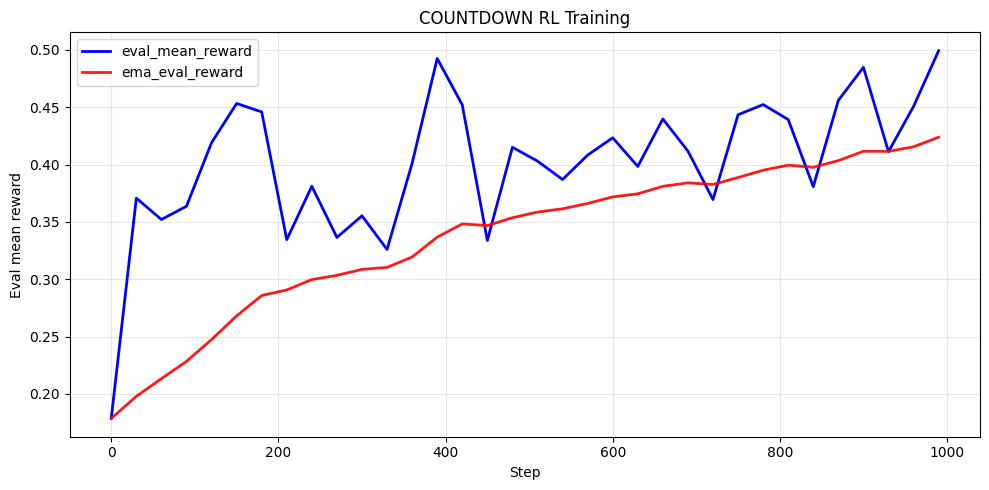

Checkpoint: tinker://ffe4ca7d-b664-4a85-9f0b-bfc931287c98/weights/COUNTDOWN-rl-final


In [19]:
final_path = training_client.save_weights_for_sampler(name="COUNTDOWN-final").result().path
final_client = service_client.create_sampling_client(model_path=final_path)

test_problems = dataset.get_batch(1, split="test")

print("Final Evaluation:")
print("=" * 60)
correct = 0

# Some backends dislike temperature=0.0; keep a safe fallback.
greedy_temp = 0.0

for i, problem in enumerate(test_problems):
    prompt_text = COUNTDOWN_FEWSHOT + problem.question
    prompt_input = make_prompt_model_input(prompt_text)

    try:
        sampling_params_greedy = types.SamplingParams(
            max_tokens=MAX_TOKENS,
            temperature=greedy_temp,
            stop=STOP_SEQS,
        )
        result = final_client.sample(
            prompt=prompt_input,
            num_samples=1,
            sampling_params=sampling_params_greedy,
        ).result()
    except Exception as e:
        print("Greedy temp=0.0 failed, retrying with temp=0.1. Error:", repr(e))
        sampling_params_greedy = types.SamplingParams(
            max_tokens=MAX_TOKENS,
            temperature=0.1,
            stop=STOP_SEQS,
        )
        result = final_client.sample(
            prompt=prompt_input,
            num_samples=1,
            sampling_params=sampling_params_greedy,
        ).result()

    response = tokenizer.decode(result.sequences[0].tokens, skip_special_tokens=True)
    reward = compute_reward(
        response_text=response,
        target=problem.target,
        nums=problem.nums,
        format_score=FORMAT_SCORE,
        use_continuous_shaping=USE_CONTINUOUS_SHAPING,
    )

    if reward >= 1.0:
        correct += 1

    status = "PASS" if reward >= 1.0 else "FAIL"
    print(f"[{i}] {problem.question[:100]}...")
    print(f"A: {response.strip()[:140]}... [{status}] reward={reward:.4f}")
    print()


# Plot eval mean reward (EMA optional)
eval_ms = [m for m in metrics_history if m.get("eval_mean_reward") is not None]
eval_steps = [m["step"] for m in eval_ms]
eval_rewards = [m["eval_mean_reward"] for m in eval_ms]

ema_ms = [m for m in metrics_history if m.get("ema_eval_reward") is not None]
ema_steps = [m["step"] for m in ema_ms]
ema_rewards = [m["ema_eval_reward"] for m in ema_ms]

print("Plot points (eval):", len(eval_steps))
if len(eval_steps) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_steps, eval_rewards, "b-", linewidth=2, label="eval_mean_reward")
    if len(ema_steps) > 0:
        plt.plot(ema_steps, ema_rewards, "r-", linewidth=2, alpha=0.9, label="ema_eval_reward")

    plt.xlabel("Step")
    plt.ylabel("Eval mean reward")
    plt.title("COUNTDOWN RL Training")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    fig_path = "COUNTDOWN_training.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
else:
    print("No eval points available to plot. (Did you set EVAL_EVERY > 0?)")


checkpoint = training_client.save_state(name="COUNTDOWN-rl-final").result()
print("Checkpoint:", checkpoint.path)